In [1]:
import urllib, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 20

In [2]:
jsonURL = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
with urllib.request.urlopen(jsonURL) as url:
    dataJSON = json.load(url)
data = pd.DataFrame.from_dict(dataJSON)
data.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1,1749-02,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
2,1749-03,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
3,1749-04,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
4,1749-05,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [3]:
# Query data from yr 2000 onwards.
milDt = data[(data['time-tag']>="2012-01") & (data['time-tag']<='2023-11')]

In [4]:
dt = data.rename(columns={'time-tag': 'date'})
dt['date'] = pd.to_datetime(dt['date'], format='%Y-%m')
dt = dt.set_index('date')
# Fill potential gaps with Null
dt = dt.asfreq('MS')
dt = dt.sort_index()
dt.head()

,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
date,,,,,,
1749-01-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-02-01,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
1749-03-01,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
1749-04-01,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
1749-05-01,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [5]:
sunspot_data = dt['ssn']
fft_result = np.fft.fft(sunspot_data)
frequencies = np.fft.fftfreq(len(sunspot_data))

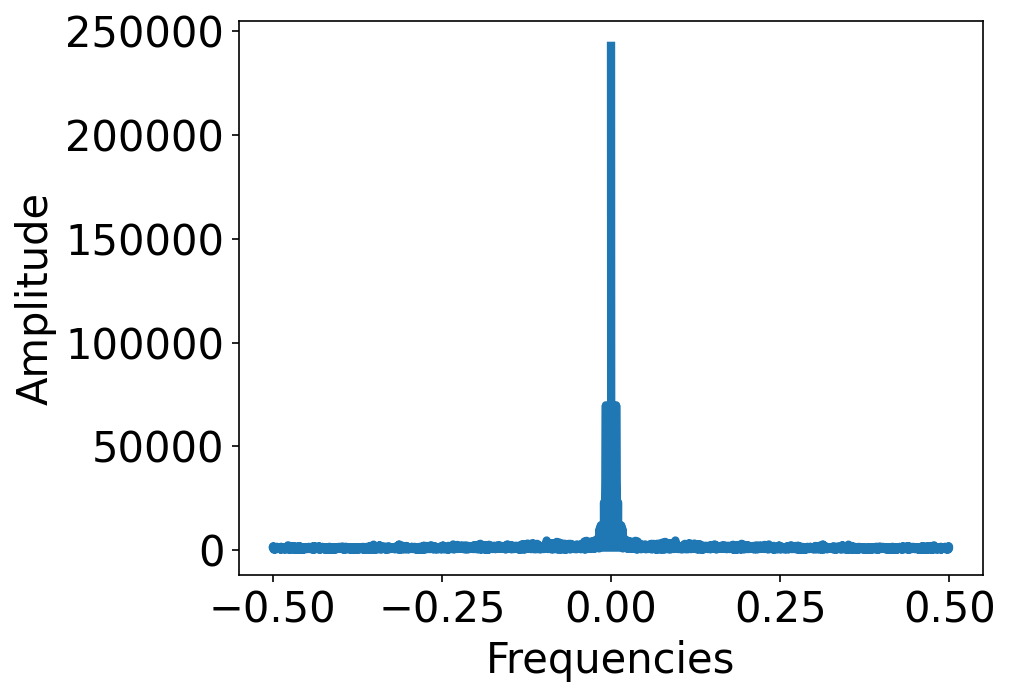

243031.75


In [11]:
plt.figure(dpi=150)
plt.plot(frequencies, np.abs(fft_result), '-')
# plt.xlim(-0.02, 0.02)
plt.xlabel('Frequencies'); plt.ylabel('Amplitude')
plt.show()

print(max(np.abs(fft_result)))

In [7]:
# Identify the peak frequency
peak_frequency = np.abs(frequencies[np.argmax(fft_result)])
print(peak_frequency)

# Calculate the period (inverse of frequency)
period = 1 / peak_frequency
print(period)

# Zero out frequencies outside a certain range
fft_result_filtered = fft_result.copy()
threshold = 0.08
fft_result_filtered[np.abs(frequencies) > threshold] = 0
print(max(fft_result_filtered))

# Reconstruct the time series
sunspot_data_reconstructed = np.real(np.fft.ifft(fft_result_filtered))
dt['sunspot_fft'] = sunspot_data_reconstructed

## Applying a scaling factor to account for lost intensity
# difference_factor = sunspot_data / np.real(sunspot_data_reconstructed)
# scaling_factor = difference_factor.mean()
# sunspot_data_reconstructed_scaled = sunspot_data_reconstructed * scaling_factor

## Extrapolating the data for n data points
months = 288
future_points = np.real(np.fft.ifft(np.pad(fft_result_filtered, (0, months))))
future_data_time_index = pd.date_range(start=dt.index[-1] + pd.DateOffset(months=1), periods=months, freq = 'MS') 

window_size = 20  # Adjust as needed
smoothed_future_points = np.convolve(future_points, np.ones(window_size)/window_size, mode='valid')

0.0
inf
(269852+0j)


C:\Users\levet\AppData\Local\Temp\ipykernel_10884\3034042060.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  period = 1 / peak_frequency


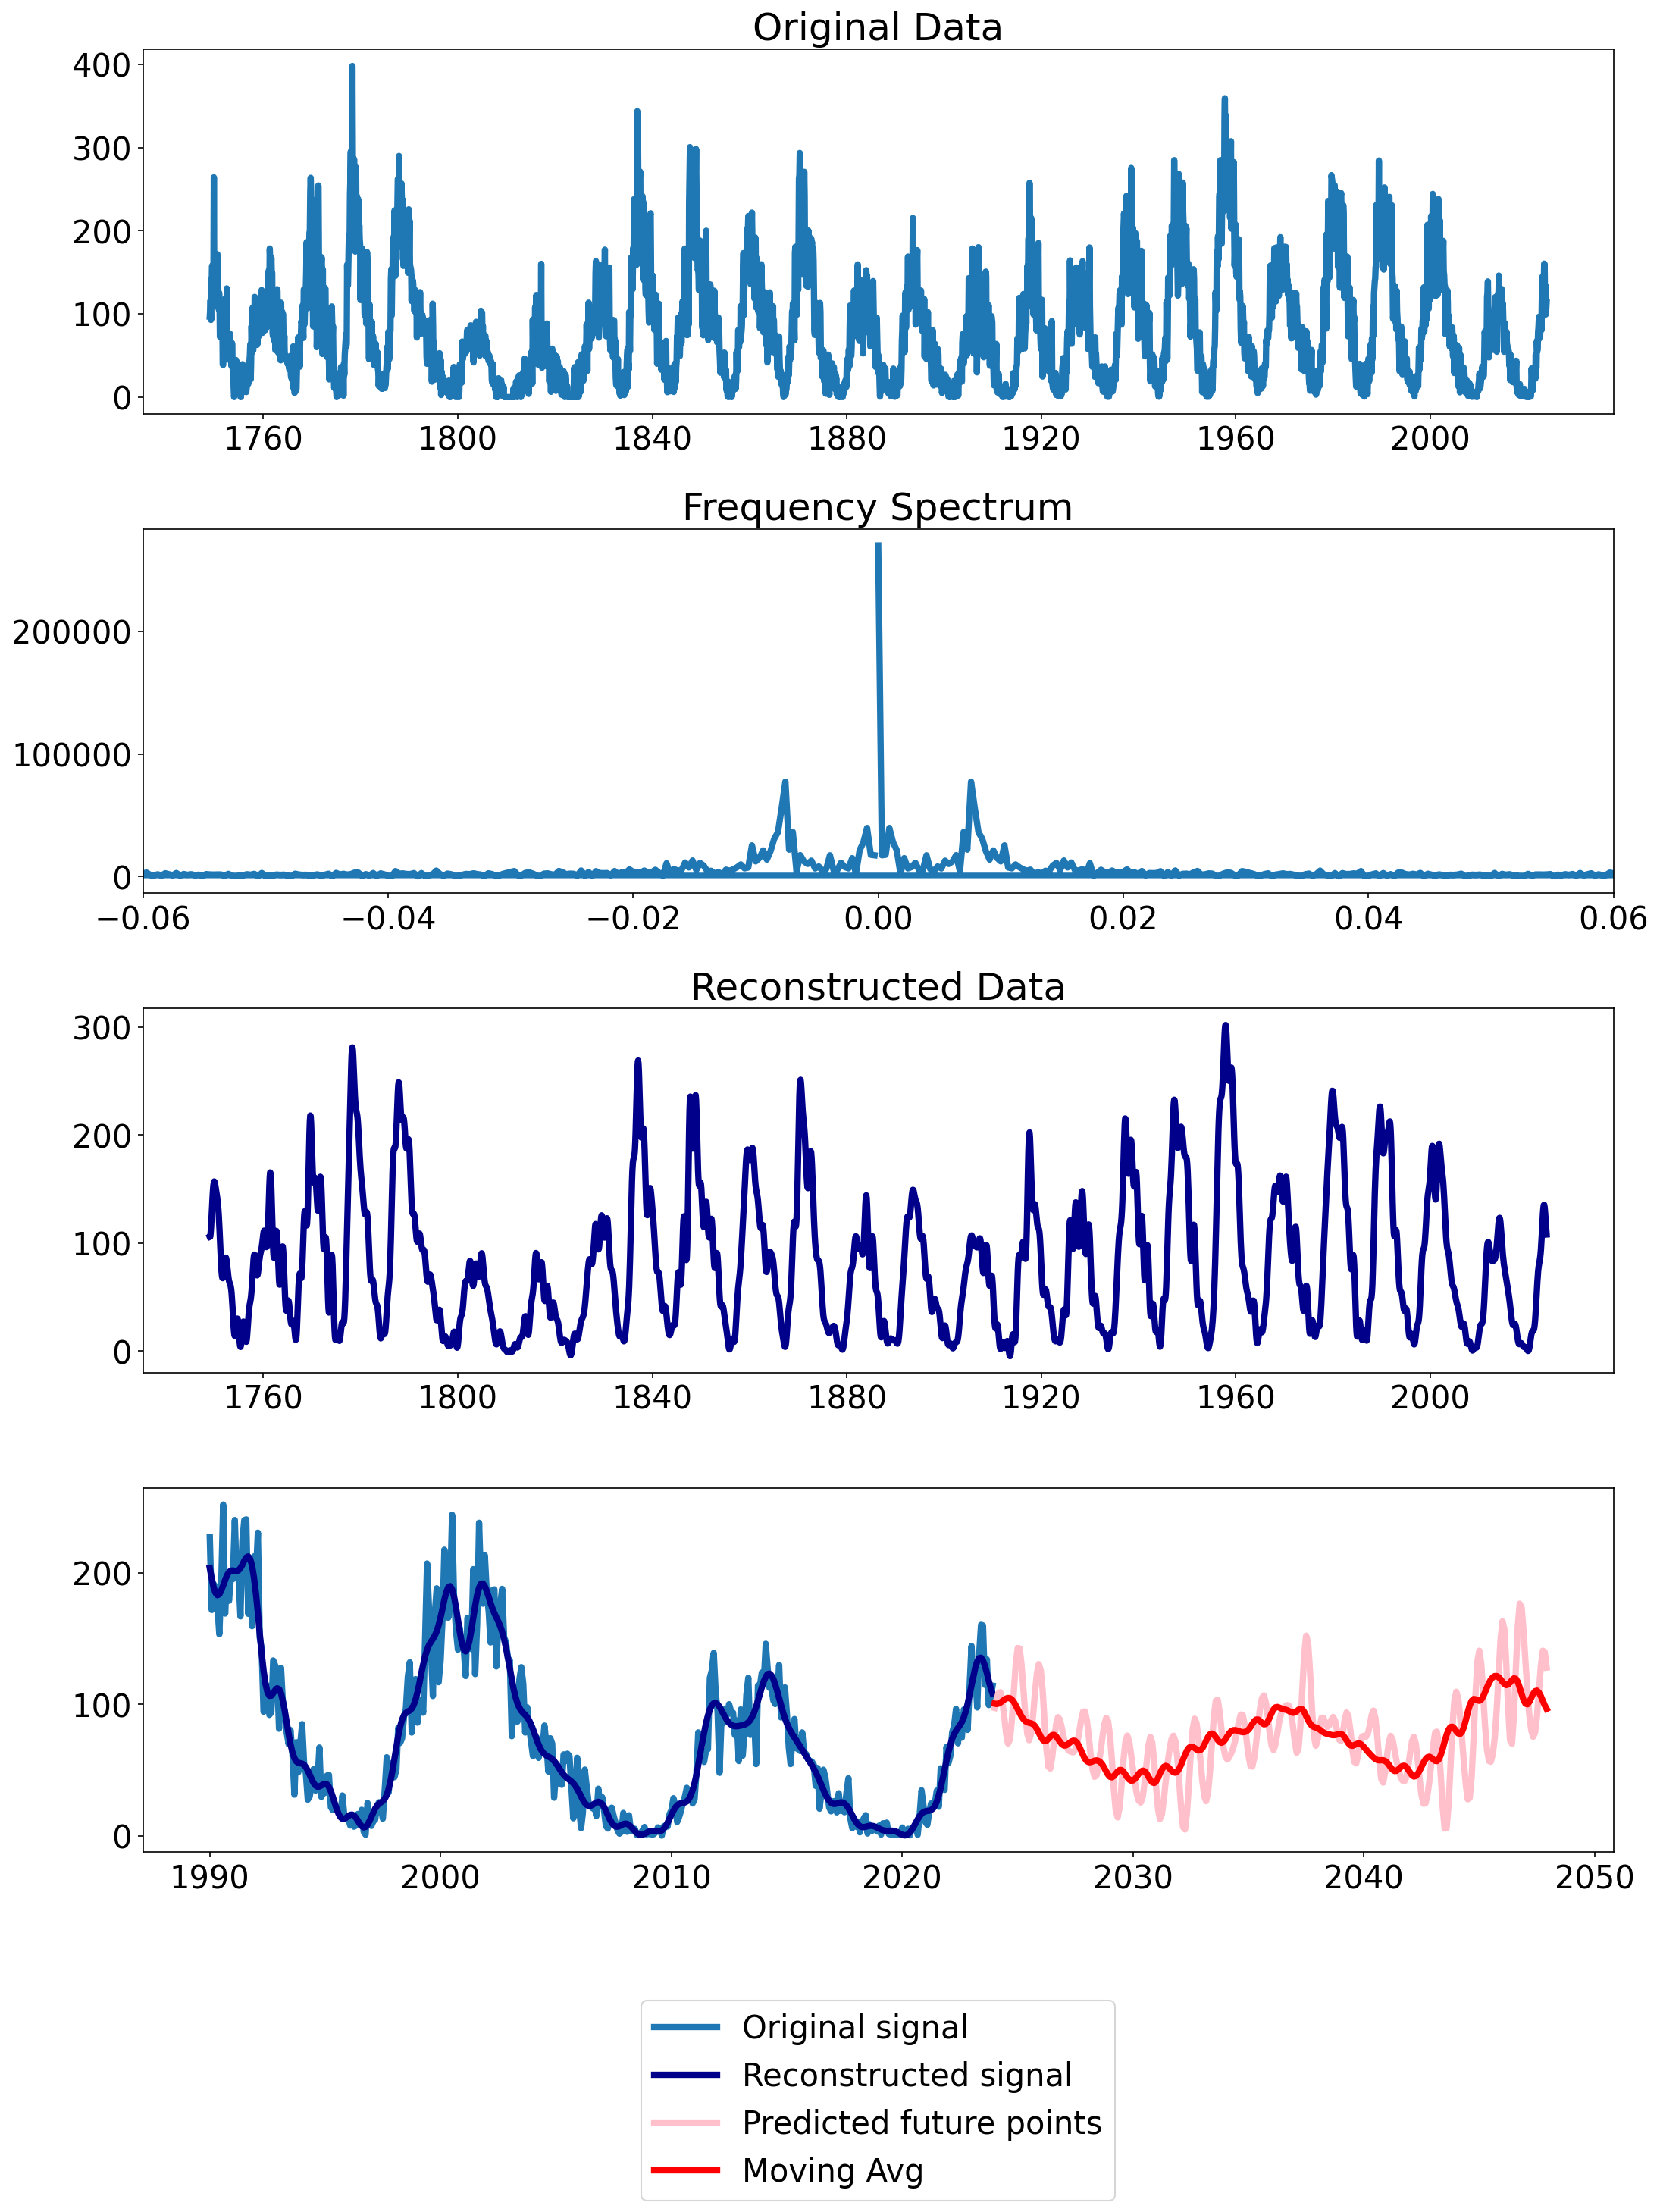

In [8]:
# Plot properties
x_width, y_width = 15, 20

# Create plot
fig, ax = plt.subplots(4, 1, figsize=(x_width, y_width), dpi=150)

ax[0].plot(sunspot_data)
ax[0].set_title('Original Data')

ax[1].plot(frequencies, np.abs(fft_result))
ax[1].set_title('Frequency Spectrum')
ax[1].set_xlim(-0.06, 0.06)

ax[2].plot(dt['sunspot_fft'], color='darkblue')
ax[2].set_title('Reconstructed Data')

sunspotFFT = dt['sunspot_fft']
ax[3].plot(sunspot_data[(sunspot_data.index>='1990')], label='Original signal')
ax[3].plot(sunspotFFT[(sunspotFFT.index>='1990')], color='darkblue', label='Reconstructed signal')
ax[3].plot(future_data_time_index, future_points[:len(future_data_time_index)], color='pink', label='Predicted future points')
ax[3].plot(future_data_time_index, smoothed_future_points[:len(future_data_time_index)], color='red', label='Moving Avg')
ax[3].legend(bbox_to_anchor =(0.5,-1), loc='lower center')

plt.tight_layout()
plt.show()

## Applying window functions

(243031.75+0j)


c:\Users\levet\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\levet\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


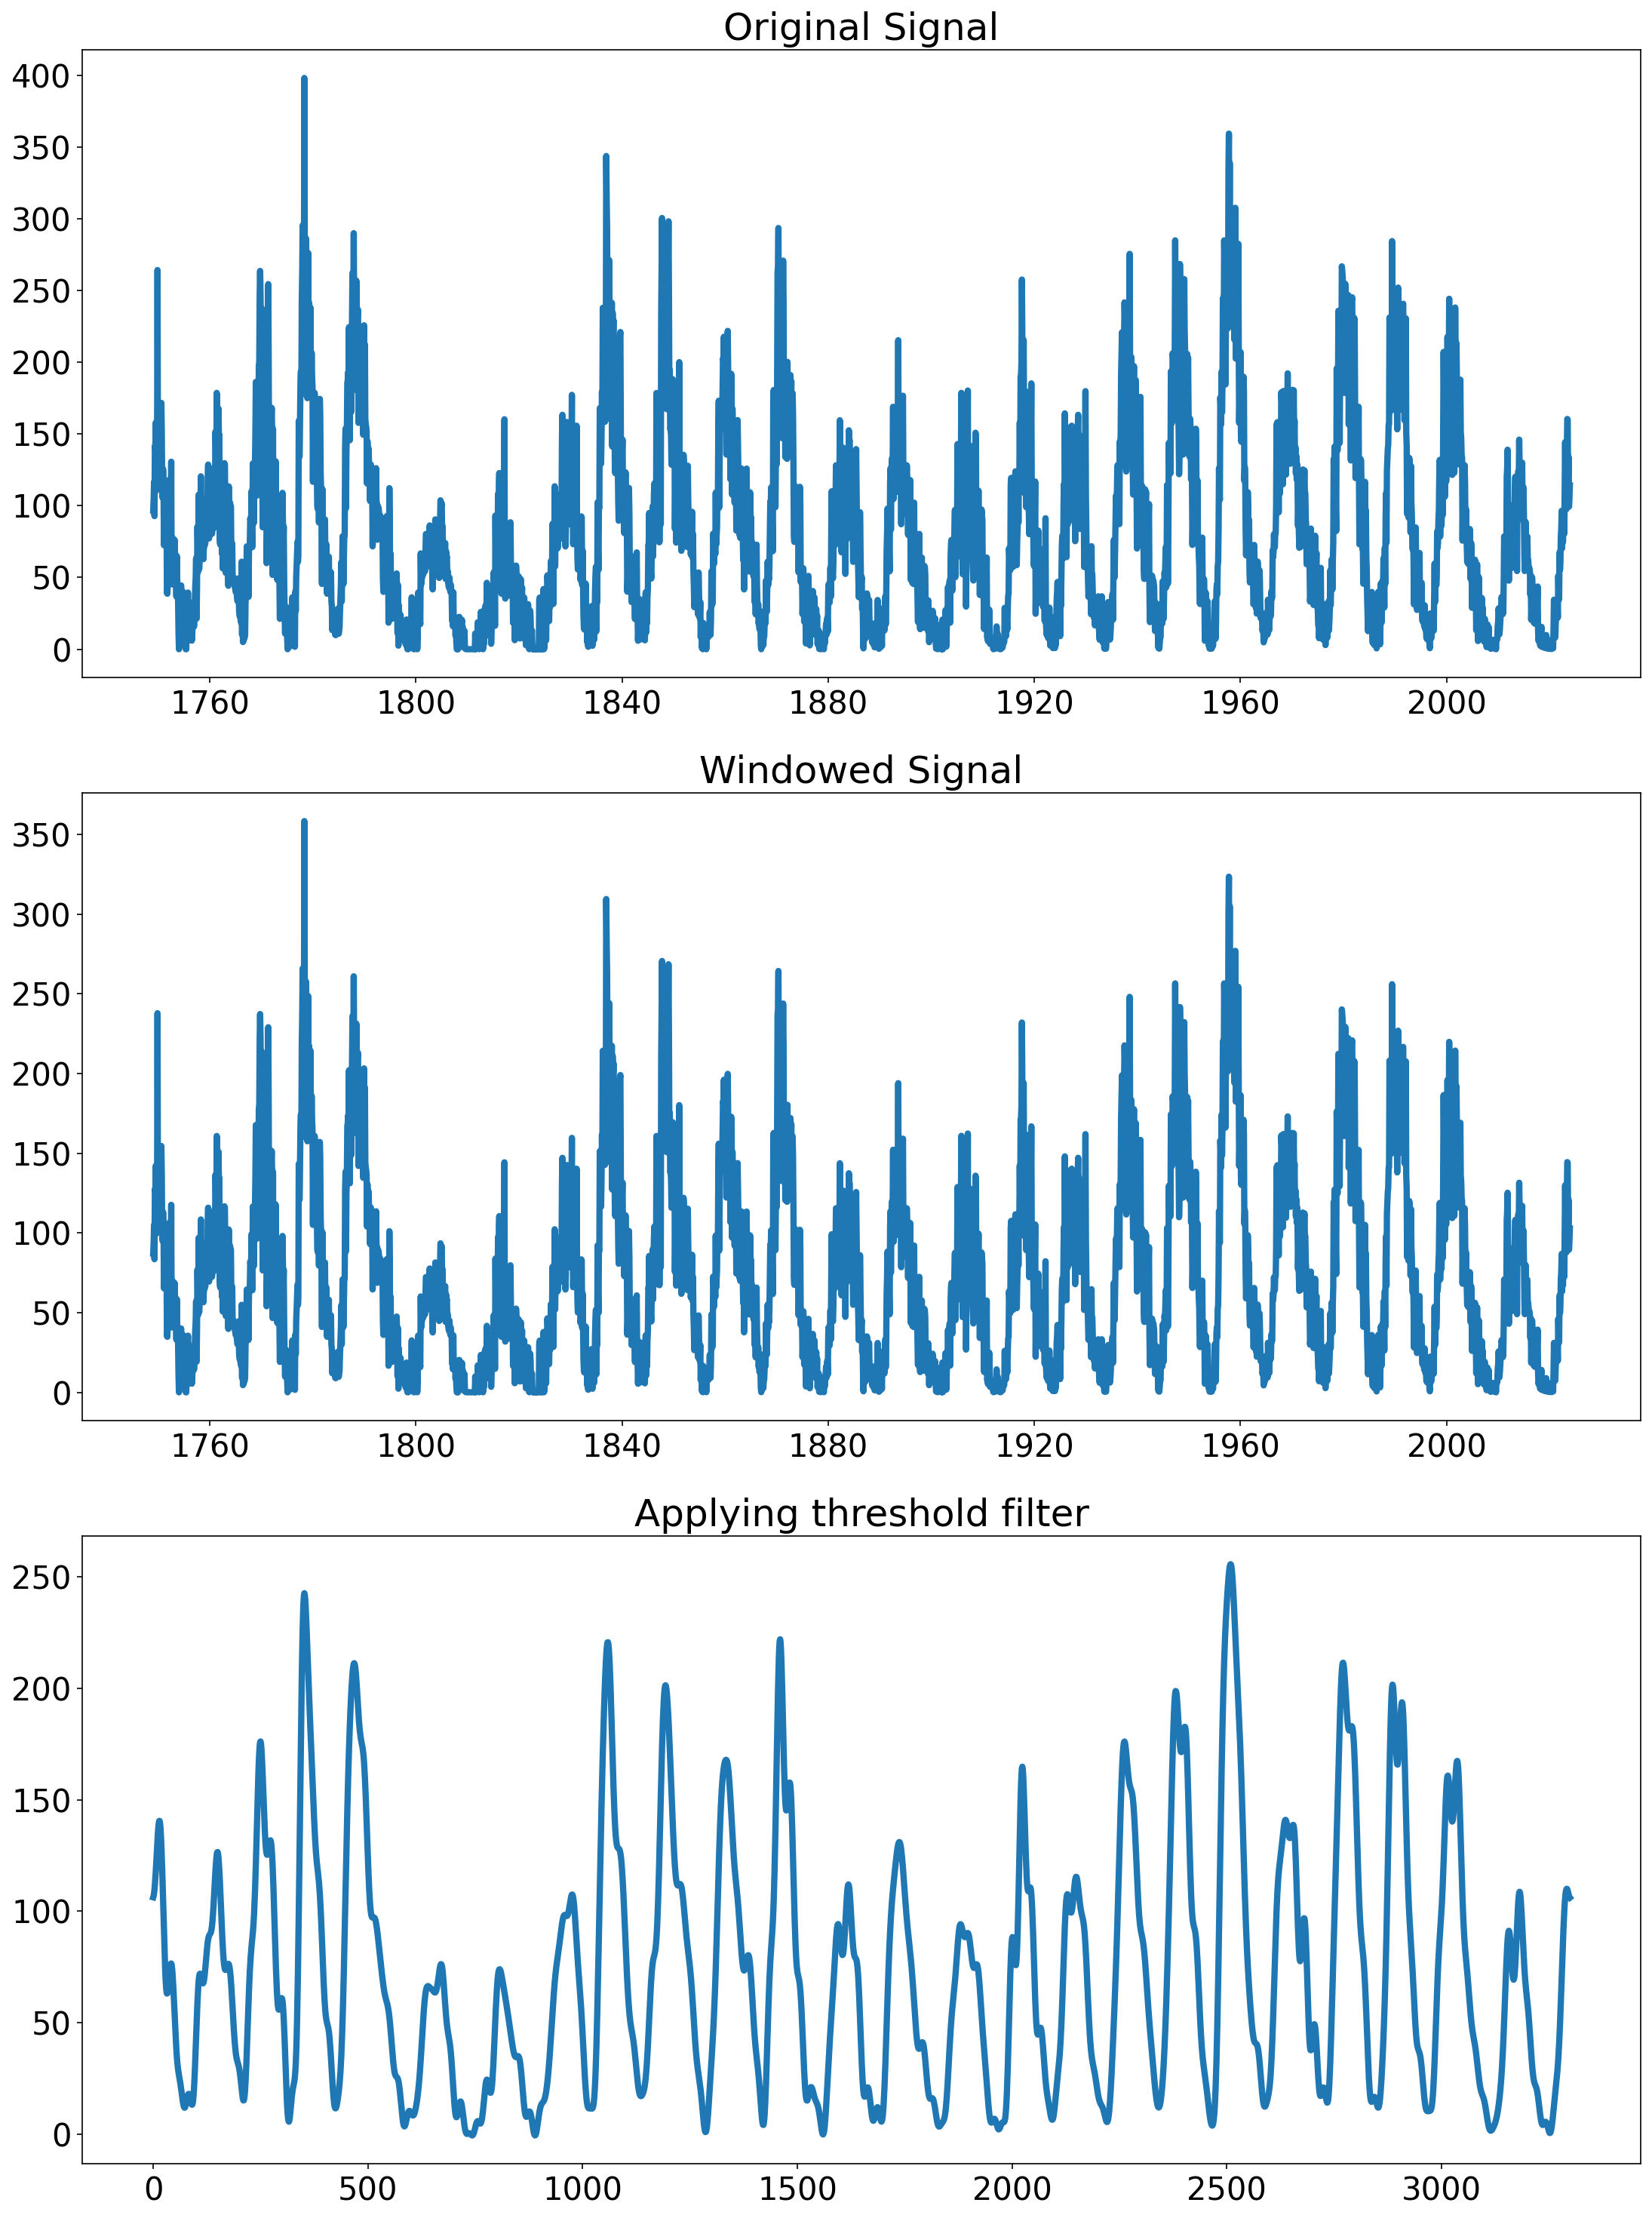

In [9]:
# Example with a smoothly tapered window
alpha = 0.1  # Adjust the smoothing factor as needed
windowed_data = sunspot_data * (1 - alpha) + np.hanning(len(sunspot_data)) * alpha


# Compute the Fourier transform of the windowed signal
fft_result = np.fft.fft(windowed_data)
frequencies = np.fft.fftfreq(len(sunspot_data))

fft_result_filtered = fft_result.copy()
threshold = 0.05
fft_result_filtered[np.abs(frequencies) > threshold] = 0
print(max(fft_result_filtered))

# Reconstruct the time series
sunspot_data_reconstructed = np.fft.ifft(fft_result_filtered)

# Visualize the original and windowed signals
fig, ax = plt.subplots(3, 1, figsize=(x_width, y_width), dpi=150)
ax[0].plot(sunspot_data)
ax[0].set_title('Original Signal')

ax[1].plot(windowed_data)
ax[1].set_title('Windowed Signal')

ax[2].plot(sunspot_data_reconstructed)
ax[2].set_title("Applying threshold filter")

plt.tight_layout()
plt.show()